In [1]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import featuretools as ft
import io
import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from dateutil.parser import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def encode_column(df, column):
    """ replaces strings with according int """
    nationalities_set = {df[column].unique()[i]: i for i in range(len(df[column].unique()))}
    df[column] = df[column].apply(lambda x: nationalities_set[x])       
    
def prepare_drivers():
    drivers = pd.read_csv("data/drivers.csv")
    # encode nationality for models
    encode_column(drivers, 'nationality')
    drivers = drivers[['driverId', 'dob', 'nationality']]
    drivers = drivers.dropna()
#     drivers['dob'] = drivers['dob'].apply(lambda x: parse(str(x)).timestamp())
    drivers['dob'] = drivers['dob'].apply(lambda x: parse(str(x)))
    return drivers

def prepare_races():
    races = pd.read_csv("data/races.csv")
    races['name'] = races['name'].apply(lambda x: x.split(" ")[0])
#     races['date'] = races['date'].apply(lambda x: parse(x).timestamp())
    races['date'] = races['date'].apply(lambda x: parse(x))
    encode_column(races, 'name')
    return races


def prepare_standing(top_x):
    standings = pd.read_csv("data/driverStandings.csv")
    standings.drop(columns=['positionText'], inplace=True)
    standings['target'] = standings['position'].apply(lambda x: 1 if x <= top_x else 0)
    
    return standings

def prepare_synthetic_table():
    first_model_input = pd.merge(standings, races, on='raceId')
    first_model_input = pd.merge(first_model_input, drivers, on='driverId')
    first_model_input = first_model_input.dropna()
    return first_model_input
    
# prepare raw data sets
drivers = prepare_drivers()
races = prepare_races()
standings = prepare_standing(5)
first_model_input = prepare_synthetic_table()

### Pipeline

- data collection
- data preparation
- feature engineering
- feature selection
- model training
- model evaluation
- repeat


##### TODO: proper cool picture
![Pipeline](bear.png "What is a data pipeline?")


### Feature Engineering

Creating new input for a model from existing data

- Domain knowledge
- Automatic approach


### Manual feature engineering

- Timestamp + [holidays](https://pypi.org/project/holidays/)
- Double click -> senior visitor
- Domain knowledge hypothesis


### Featuretools

[Featuretools](https://github.com/Featuretools/featuretools)


In [3]:
drivers.head()

,driverId,dob,nationality
0,1,1985-07-01,0
1,2,1977-10-05,1
2,3,1985-06-27,1
3,4,1981-07-29,2
4,5,1981-10-19,3


In [4]:
races.head()

,raceId,year,round,circuitId,name,date
0,1,2009,1,1,0,2009-03-29
1,2,2009,2,2,1,2009-04-05
2,3,2009,3,17,2,2009-04-19
3,4,2009,4,3,3,2009-04-26
4,5,2009,5,4,4,2009-05-10


In [5]:
standings.head()

,driverStandingsId,raceId,driverId,points,position,wins,target
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,0,1
2,3,18,3,6.0,3,0,1
3,4,18,4,5.0,4,0,1
4,5,18,5,4.0,5,0,1


### Predict that a pilot will be in top X for the race (Calssify as top pilot)
Possible input for predictions:
- driverId
- date_of_birth
- nationality

- raceId
- name
- date

Fatures:
- driverId
- dob -> split into year and month (almost always a default transformation)
- nationality
- raceId
- date -> split into year and month (almost always a default transformation)
- name

In [6]:
simple_model_df = pd.merge(standings, drivers, on='driverId')
simple_model_df = pd.merge(simple_model_df, races, on='raceId')
simple_model_df.drop(columns=['driverStandingsId', 'position', 'wins', 'year', 'round', 'circuitId', 'points'], inplace=True)
simple_model_df = simple_model_df.dropna()
simple_model_df['dob_year'] = simple_model_df['dob'].apply(lambda x: x.year)
simple_model_df['dob_month'] = simple_model_df['dob'].apply(lambda x: x.month)
simple_model_df['race_year'] = simple_model_df['date'].apply(lambda x: x.year)
simple_model_df['race_month'] = simple_model_df['date'].apply(lambda x: x.month)
simple_model_df.drop(columns=['dob', 'date'], inplace=True)

In [7]:
simple_model_df.head()

,raceId,driverId,target,nationality,name,dob_year,dob_month,race_year,race_month
0,18,1,1,0,0,1985,7,2008,3
1,18,2,1,1,0,1977,10,2008,3
2,18,3,1,1,0,1985,6,2008,3
3,18,4,1,2,0,1981,7,2008,3
4,18,5,1,3,0,1981,10,2008,3


In [8]:
train = simple_model_df[:int(simple_model_df.shape[0]*0.75)]
train_Y = train['target']
train_X = train.drop(columns=['target'])
test = simple_model_df[int(simple_model_df.shape[0]*0.75):]
test_Y = test['target']
test_X = test.drop(columns=['target'])

model_simple = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model_simple.fit(train_X, train_Y)  
simple_prediction = model_simple.predict(test_X)
mse_simple = mean_squared_error(test_Y.to_list(), simple_prediction)
mse_simple

0.08696808510638297

### Can we improve by adding features?
- How old was a pilot when taking part at race X
- Is pilot from host country
- Is pilot young?
...

Let's automate this questions

In [9]:
# small preparation so that we do not get any target exposure
standings_simple = standings[['driverId', 'raceId', 'target', 'driverStandingsId']]
target = standings_simple[['target', 'driverId']]
standings_simple.drop(columns=['target'], inplace=True)
race_simple = races[['raceId', 'date', 'name']]

In [10]:
# Entity set
es = ft.EntitySet(id = 'top_formula_pilot')
# Entities
es = es.entity_from_dataframe(entity_id="drivers",
                              dataframe=drivers,
                              index="driverId",
                              variable_types={"nationality": ft.variable_types.Categorical,
                                              "dob": ft.variable_types.DateOfBirth})
es = es.entity_from_dataframe(entity_id="standings",
                              dataframe=standings_simple,
                              index="driverStandingsId",
                              variable_types={"raceId": ft.variable_types.Id,
                                              "driverId": ft.variable_types.Id})
es = es.entity_from_dataframe(entity_id="races",
                              dataframe=race_simple,
                              index="raceId",
                              variable_types={"name": ft.variable_types.Categorical,
                                              "date": ft.variable_types.Datetime})



In [11]:
# Relationship
es = es.add_relationship(ft.Relationship(es["drivers"]["driverId"], es["standings"]["driverId"]))
es = es.add_relationship(ft.Relationship(es["races"]["raceId"], es["standings"]["raceId"]))

In [12]:
feature_matrix, feature_defs = ft.dfs(entityset=es, 
                                      target_entity="drivers",
                                      max_depth = 4)

In [13]:
feature_matrix = feature_matrix.dropna()
feature_matrix = pd.merge(feature_matrix, target, on='driverId')
train = feature_matrix[:int(feature_matrix.shape[0]*0.75)]
train_Y = train['target']
train_X = train.drop(columns=['target'])
test = feature_matrix[int(feature_matrix.shape[0]*0.75):]
test_Y = test['target']
test_X = test.drop(columns=['target'])



model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model.fit(train_X, train_Y)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [14]:
complex_predictions = model.predict(test_X)
mse_extended = mean_squared_error(test_Y.to_list(), complex_predictions)
mse_extended

0.07271496276235613

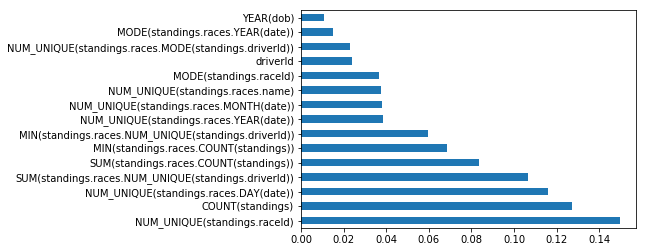

In [15]:
feat_importances = pd.Series(model.feature_importances_, index=train_X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [16]:
feature_matrix.columns

Index(['driverId', 'nationality', 'COUNT(standings)',
       'NUM_UNIQUE(standings.raceId)', 'MODE(standings.raceId)', 'DAY(dob)',
       'YEAR(dob)', 'MONTH(dob)', 'WEEKDAY(dob)',
       'NUM_UNIQUE(standings.races.name)', 'MODE(standings.races.name)',
       'SUM(standings.races.COUNT(standings))',
       'SUM(standings.races.NUM_UNIQUE(standings.driverId))',
       'STD(standings.races.COUNT(standings))',
       'STD(standings.races.NUM_UNIQUE(standings.driverId))',
       'MAX(standings.races.COUNT(standings))',
       'MAX(standings.races.NUM_UNIQUE(standings.driverId))',
       'SKEW(standings.races.COUNT(standings))',
       'SKEW(standings.races.NUM_UNIQUE(standings.driverId))',
       'MIN(standings.races.COUNT(standings))',
       'MIN(standings.races.NUM_UNIQUE(standings.driverId))',
       'MEAN(standings.races.COUNT(standings))',
       'MEAN(standings.races.NUM_UNIQUE(standings.driverId))',
       'NUM_UNIQUE(standings.races.MODE(standings.driverId))',
       'NUM_UNIQUE(

### Feature Selection

· Reduces Overfitting #DitchTheNoise

· Improves Accuracy #ImportantFeaturesAreImportant

· Reduces Training Time #LessComplexIsFaster


### How to?

- manually take out features that make sense
- automatically try different sets of features

### Manually defined:

- Univariate Selection

- Feature Importance

- Correlation Matrix with Heatmap

good article: [feature_selection](https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e)

In [17]:
from sklearn.feature_selection import SelectFromModel
print("Old sdata shape: {}".format(train_X.shape))
new_model = SelectFromModel(model, prefit=True)
X_new = new_model.transform(train_X)
print("New data shape: {}".format(X_new.shape))

Old sdata shape: (22154, 33)
New data shape: (22154, 11)


In [18]:
mask = new_model.get_support()
assert len(mask) == train_X.shape[1]
old_features = list(train_X.columns)
good_features = [old_features[i] for i in range(len(mask)) if mask[i]]
good_features.append('driverId')
good_features

['COUNT(standings)',
 'NUM_UNIQUE(standings.raceId)',
 'MODE(standings.raceId)',
 'NUM_UNIQUE(standings.races.name)',
 'SUM(standings.races.COUNT(standings))',
 'SUM(standings.races.NUM_UNIQUE(standings.driverId))',
 'MIN(standings.races.COUNT(standings))',
 'MIN(standings.races.NUM_UNIQUE(standings.driverId))',
 'NUM_UNIQUE(standings.races.DAY(date))',
 'NUM_UNIQUE(standings.races.YEAR(date))',
 'NUM_UNIQUE(standings.races.MONTH(date))',
 'driverId']

In [25]:
new_feature_matrix = feature_matrix[good_features].copy()
new_feature_matrix = pd.merge(new_feature_matrix, target, on='driverId')
new_feature_matrix.drop(columns=['driverId'], inplace=True)
new_train = new_feature_matrix[:int(new_feature_matrix.shape[0]*0.75)]
new_train_Y = new_train['target']
new_train_X = new_train.drop(columns=['target'])
new_test = new_feature_matrix[int(new_feature_matrix.shape[0]*0.75):]
new_test_Y = new_test['target']
new_test_X = new_test.drop(columns=['target'])

In [26]:
new_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
new_model.fit(new_train_X, new_train_Y)  
new_predict = new_model.predict(new_test_X)
new_mse_extended = mean_squared_error(new_test_Y.to_list(), new_predict)
new_mse_extended  # Lol+)

0.1852242578573355

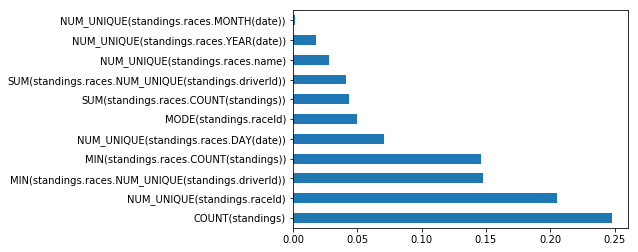

In [27]:
feat_importances = pd.Series(new_model.feature_importances_, index=new_train_X.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

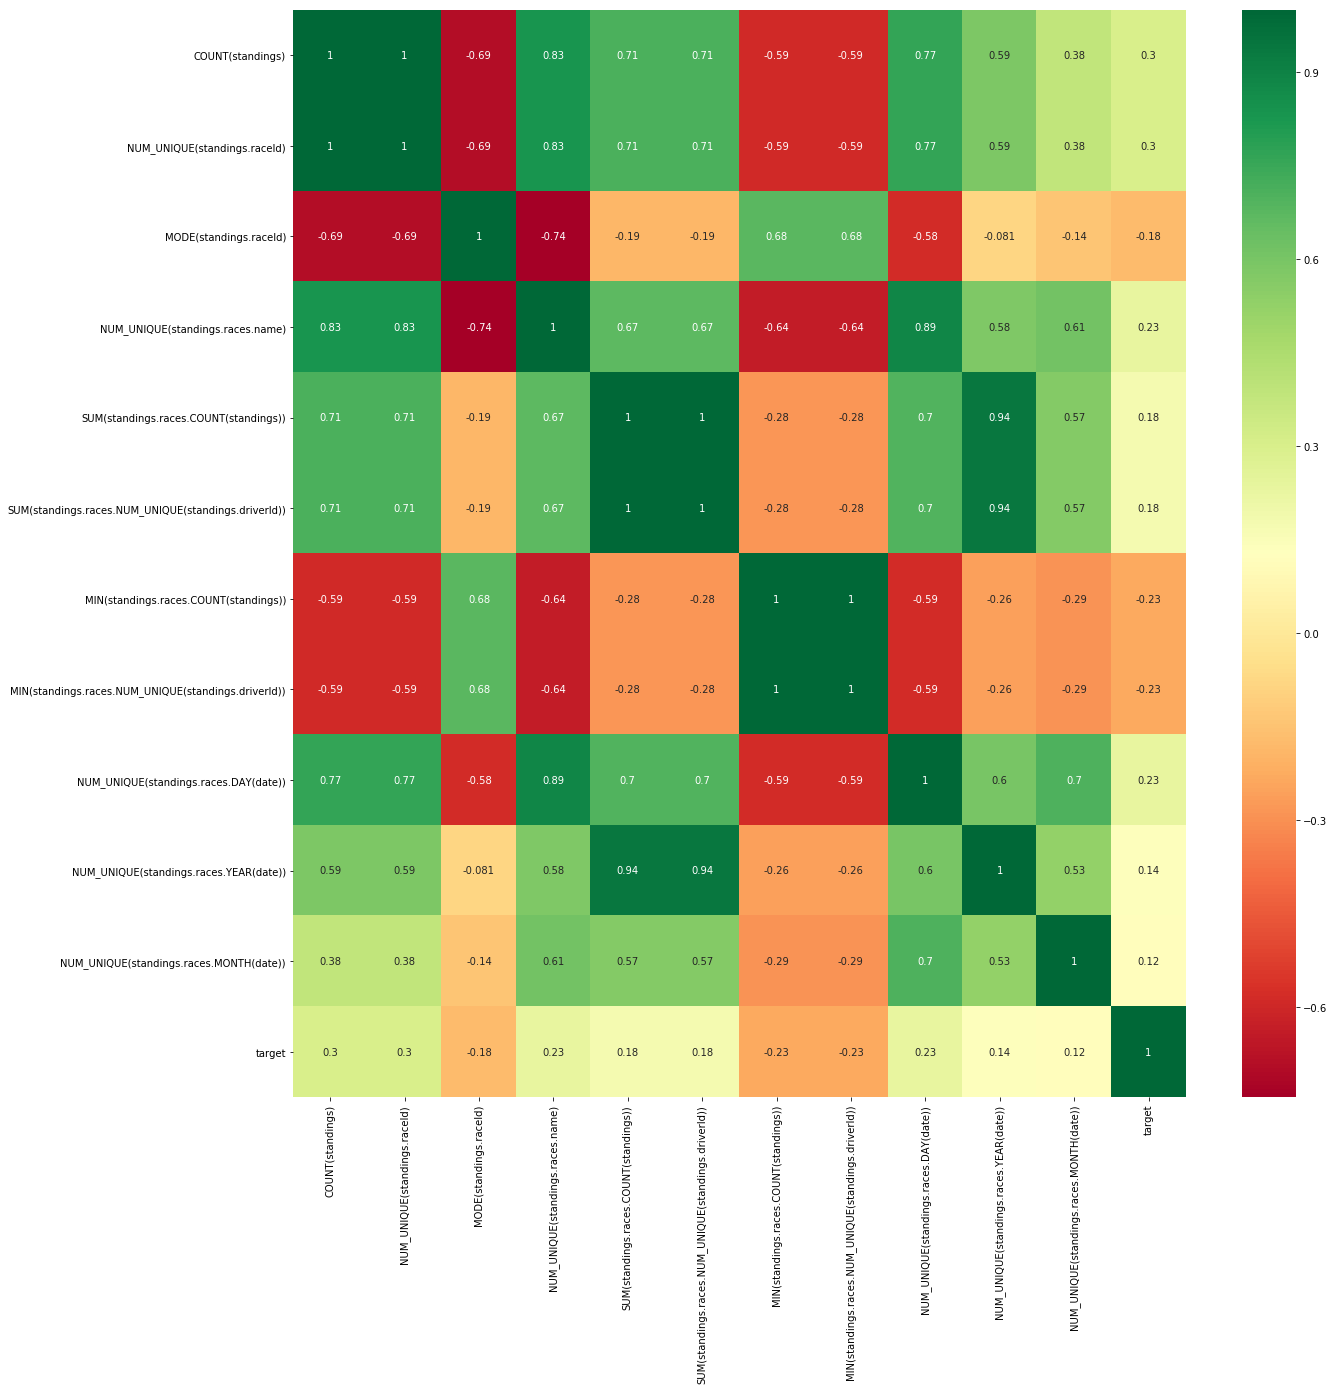

In [29]:
#get correlations of each features in dataset
corrmat = new_feature_matrix.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(new_feature_matrix[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [30]:
from sklearn.feature_selection import GenericUnivariateSelect

trans = GenericUnivariateSelect(score_func=lambda train_X, train_Y: train_X.mean(axis=0), mode='percentile', param=50)
X = model.fit_transform(train_X, train_Y)


AttributeError: 'RandomForestClassifier' object has no attribute 'fit_transform'